# <center>SWAE</center>

Let $f$ be an encoder and $g$ a decoder. We want to put some prior $p_Z$. Denote $\mu$ the target distribtuion.  Then, [1] proposes to use as loss:
\begin{equation}
    \mathcal{L}(f,g) = \int c\big(x, g(f(x))\big) \mathrm{d}\mu(x) + \lambda \ SW_2^2(f_\#\mu, p_Z).
\end{equation}
The first term is an upper bound of the Wasserstein distance and can be approximated by
\begin{equation}
    \int c\big(x, g(f(x))\big) \mathrm{d}\mu(x) \approx \frac{1}{M}\sum_{m=1}^M c\big(x_m,g(f(x_m))\big),
\end{equation}
where $x_m\sim \mu$ iid. This term enforces to reconstruct the data, and the SW distance enforeces to match some prior distribution.

Note that they further add a $L^1$ penalty to avoid to prevent variance collapse on latent variables.

For implementations, see https://github.com/skolouri/swae in keras or https://github.com/eifuentes/swae-pytorch in pytorch.

[1] Kolouri, Soheil, et al. "Sliced Wasserstein auto-encoders." International Conference on Learning Representations. 2018.

In [1]:
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from tqdm.auto import trange
from sklearn.datasets import make_circles

from sw import sliced_wasserstein

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=500, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

### AutoEncoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_filter, d=48):
        super().__init__()
        self.num_filter = num_filter
        self.conv1 = nn.Conv2d(1, self.num_filter, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter, self.num_filter, 
                               kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv3 = nn.Conv2d(self.num_filter, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(self.num_filter*2, self.num_filter*2,
                               kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*4, 
                               kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*4, self.num_filter*4,
                               kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, padding=1)        
        
        self.fc1 = nn.Linear(int(self.num_filter*4*4*4), 128)
        self.fc2 = nn.Linear(128, d)
                
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.pool1(F.leaky_relu(self.conv2(out), 0.2))
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.pool2(F.leaky_relu(self.conv4(out), 0.2))
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.pool3(F.leaky_relu(self.conv6(out), 0.2))
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
    

class Decoder(nn.Module):
    def __init__(self, num_filter, bottleneck_size=48):
        super().__init__()
        self.num_filter = num_filter

        self.fc4 = nn.Linear(bottleneck_size, 128)
        self.fc5 = nn.Linear(128, self.num_filter*4*4*4)
        
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(self.num_filter*4, self.num_filter*4, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(self.num_filter*4, self.num_filter*2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(self.num_filter*2, self.num_filter*2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(self.num_filter*2, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        d = self.num_filter
        out = torch.relu(self.fc5(self.fc4(x)))
        out = out.view(-1, 4*d, 4, 4)
        
        out = F.leaky_relu(self.conv1(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(self.upsample(out)), 0.2)

        out = torch.sigmoid(self.conv6(out))
        return out
    
    
class AE(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.encoder = Encoder(input_shape, d)
        self.decoder = Decoder(input_shape, d)
    
    def forward(self, x):
        z = self.encoder(x)        
        y = self.decoder(z)
        return y

In [23]:
## https://github.com/eifuentes/swae-pytorch/blob/763f771c1d4860f71819af48d4f21a8a29a689d5/swae/distributions.py#L38

def rand_ring2d(batch_size):
    """ This function generates 2D samples from a hollowed-cirlce distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    circles = make_circles(2 * batch_size, noise=.01)
    z = np.squeeze(circles[0][np.argwhere(circles[1] == 0), :])
    return torch.from_numpy(z).type(torch.FloatTensor)


def rand_circle2d(batch_size):
    """ This function generates 2D samples from a filled-circle distribution in a 2-dimensional space.
        Args:
            batch_size (int): number of batch samples
        Return:
            torch.Tensor: tensor of size (batch_size, 2)
    """
    r = np.random.uniform(size=(batch_size))
    theta = 2 * np.pi * np.random.uniform(size=(batch_size))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.array([x, y]).T
    return torch.from_numpy(z).type(torch.FloatTensor)

In [6]:
def val_mnist(model, latent_dim=2, latent_distr="unif"):
    model.eval()

    torch.manual_seed(42)
    r,c = 5,5
    if latent_distr == "unif":
        z = -1+2*torch.rand(r*c, latent_dim, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         z = F.normalize(g, p=2, dim=1)
        z = rand_ring2d(r*c).to(device)
    elif latent_distr == "circle":
        z = rand_circle2d(r*c).to(device)
        
    gen_imgs = model.decoder(z).reshape(-1,28,28).detach().cpu()

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs[cpt],"gray")
            ax[i,j].axis('off')

            cpt += 1
                
    fig.set_size_inches(6, 6)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_latent(model, test_loader):
    model.eval()

    test_encode, test_targets = [], []
    for x_val, y_val in test_loader:
        x_val = x_val.to(device)

        zhat = model.encoder(x_val)
        yhat = model.decoder(zhat)
        test_encode.append(zhat.detach())
        test_targets.append(y_val.detach())
    
    test_encode = torch.cat(test_encode).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    
    # Distribution of the encoded samples
    z = test_encode
    Y = test_targets

    plt.figure(figsize=(10,10))
    plt.scatter(z[:,0], -z[:,1], c=10*Y, cmap=plt.cm.Spectral)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.show()

### SWAE

In [16]:
criterion = nn.BCELoss(reduction='mean')

def ae_loss(x, y, z, latent_distr="unif"):
    n, d = z.size()
    
    if latent_distr == "unif":
        target_latent = -1+2*torch.rand(n, d, device=device)
    elif latent_distr == "ring":
#         g = torch.randn(n, d, device=device)
#         target_latent = F.normalize(g, p=2, dim=1)
        target_latent = rand_ring2d(n).to(device)
    elif latent_distr == "circle":
        target_latent = rand_circle2d(n).to(device)

    sw = sliced_wasserstein(z, target_latent, 1000, device, p=2)
    l1 = F.l1_loss(y, x) # torch.mean(torch.abs(x-y))
    reconstruction_loss = criterion(y, x)    
    return reconstruction_loss+l1+10.0*sw

In [9]:
def train(model, optimizer, n_epochs, train_loader, test_loader, latent_distr="unif", plot_val=False):
    pbar = trange(n_epochs)

    losses = []
    val_losses = []

    for e in pbar:
        loss_epoch = 0
        cpt_batch = 0

        for x_batch, _ in train_loader:
            x_batch = x_batch.to(device)

            model.train()

            z_hat = model.encoder(x_batch)
            y_hat = model.decoder(z_hat)

            l = ae_loss(x_batch, y_hat, z_hat, latent_distr)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_epoch += l.item()/x_batch.size(0)
            cpt_batch += 1

        losses.append(loss_epoch/cpt_batch)

        loss_val_epoch = 0
        cpt_batch = 0

        with torch.no_grad():
            for x_val, _ in test_loader:
                x_val = x_val.to(device)

                model.eval()
                zhat = model.encoder(x_val)
                yhat = model.decoder(zhat)
                val_l = ae_loss(x_val,yhat,zhat,latent_distr)
                loss_val_epoch += val_l.item()/x_val.size(0)
                cpt_batch += 1

            val_losses.append(loss_val_epoch/cpt_batch)

        print(e,losses[-1],val_losses[-1])

        if e%10 == 0 and plot_val:  
            with torch.no_grad():
                model.eval()
                for x_val, _ in test_loader:
                    fig,ax = plt.subplots(1,2,figsize=(10,10))

                    ax[0].imshow(x_val[0][0],"gray")

                    x_val = x_val.to(device)

                    model.eval()
                    yhat = model(x_val[0][0].reshape(-1,28,28))
                    yhat = yhat.reshape(-1,1,28,28)
                    ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
                    plt.show()

                    break

                plot_latent(model, test_loader)
                
    if plot_val:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()
        plt.show()


In [10]:
model = AE(16, 2).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.9)

In [11]:
print(model)

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (fc1): Linear(in_features=1024, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc4): Linear(in_features=2, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1024, bias=True)
    (upsample): Upsample(scale_factor=2.0, m

#### Latent=Unif

  0%|          | 0/51 [00:00<?, ?it/s]

0 0.004025304772953194 0.08505109659494303


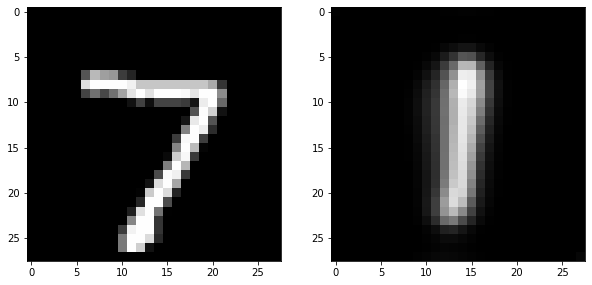

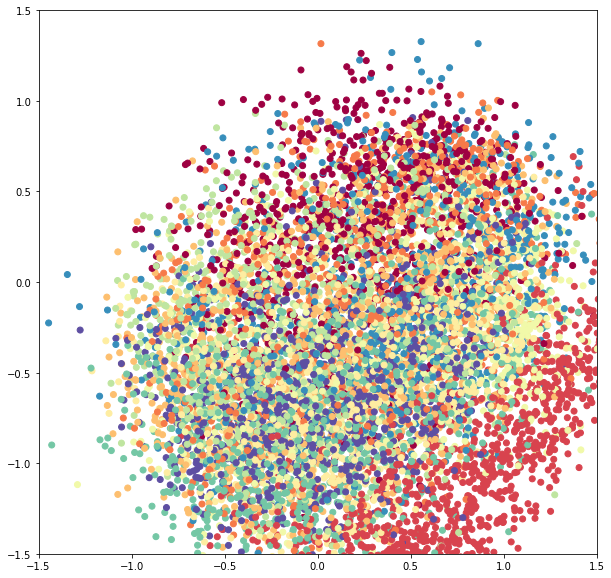

1 0.0014527083754539488 0.04613752377490266
2 0.0010336662590503688 0.039396421287577754
3 0.000925978523989518 0.0358836874425316
4 0.0008586215570569037 0.03716755234680998
5 0.0008102114275097845 0.034628197235373644
6 0.0007841451048851008 0.03591678981273509
7 0.0007642973393201826 0.03498616806282022
8 0.000759064230322838 0.032127455965922286
9 0.0007397185121973353 0.03201895030721213
10 0.0007388843307892476 0.0329693829545531


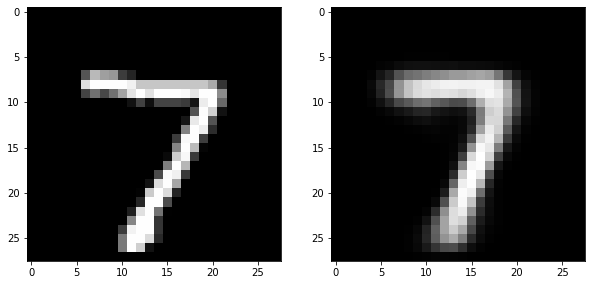

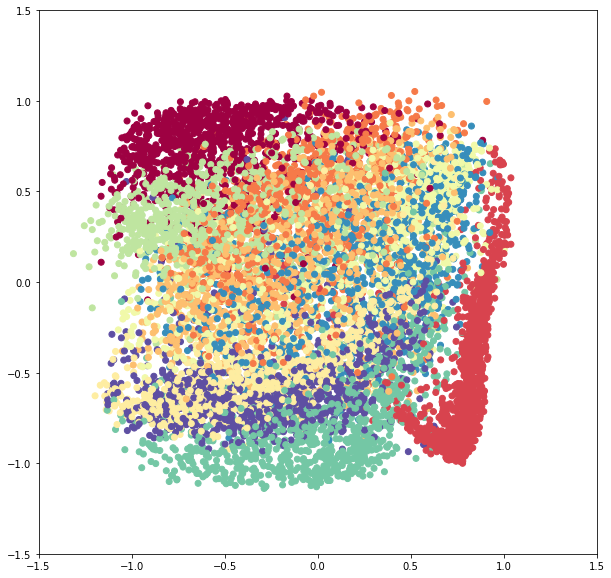

11 0.000731168750921885 0.033372710932034276
12 0.0007118794774015744 0.03256611335879793
13 0.0007001590341329576 0.033887312664224886
14 0.0006960466658075649 0.034171362767537565
15 0.0006984124198555947 0.0333520658522511
16 0.000695925650993983 0.032795542455352725
17 0.0006912735144297282 0.034466189570344107
18 0.0006809871370593711 0.0314372438794603
19 0.000678220867117246 0.03353735416258771
20 0.0006768163189291955 0.03079630161959904


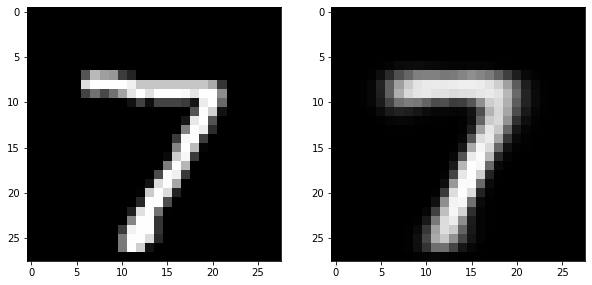

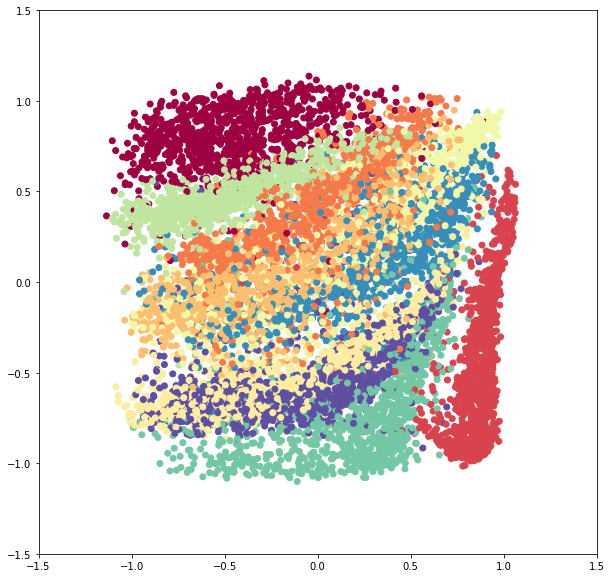

21 0.0006718996122479439 0.03486270263207892
22 0.0006703915754954023 0.032514231490750854
23 0.0006638094966610271 0.031884300590942084
24 0.0006702094917496047 0.03164828346726803
25 0.0006600554659962651 0.03290048726914695
26 0.0006554723372062044 0.03155576694494905
27 0.000654585095743338 0.032275224015259514
28 0.0006504647746682167 0.03142784801892008
29 0.0006452095001935957 0.03338308129519129
30 0.0006445424626270929 0.03321961550928724


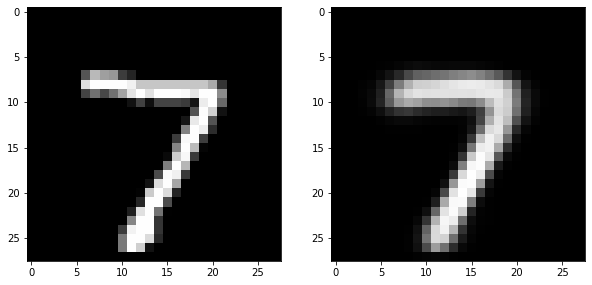

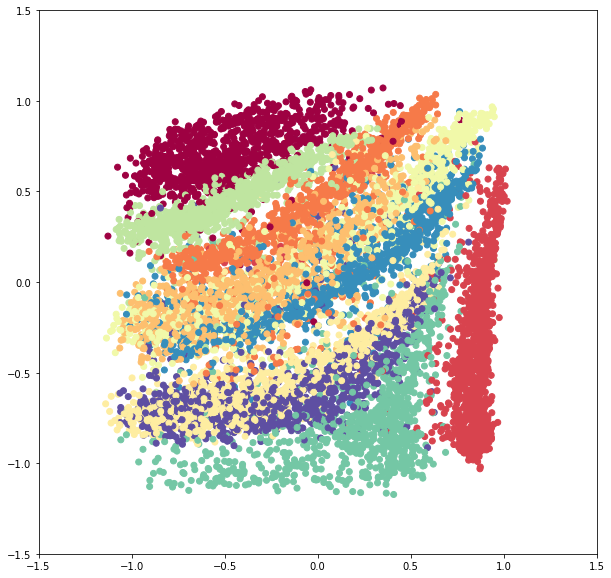

31 0.0006383437479535741 0.03183874363502184
32 0.0006443169598778087 0.032769082384868364
33 0.0006414116725325581 0.03025002166712151
34 0.0006376782606045405 0.03235512468428277
35 0.0006321520224213602 0.03127041867318245
36 0.000631948215762774 0.03246439632159262
37 0.0006375321527322132 0.03248961088649286
38 0.000623311097919941 0.030565901635625302
39 0.0006338411629199984 0.0320492317965522
40 0.0006343678936362267 0.03245354929980569


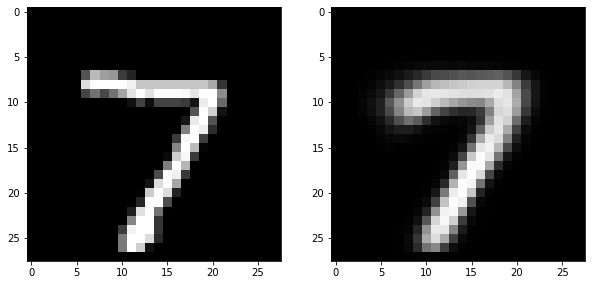

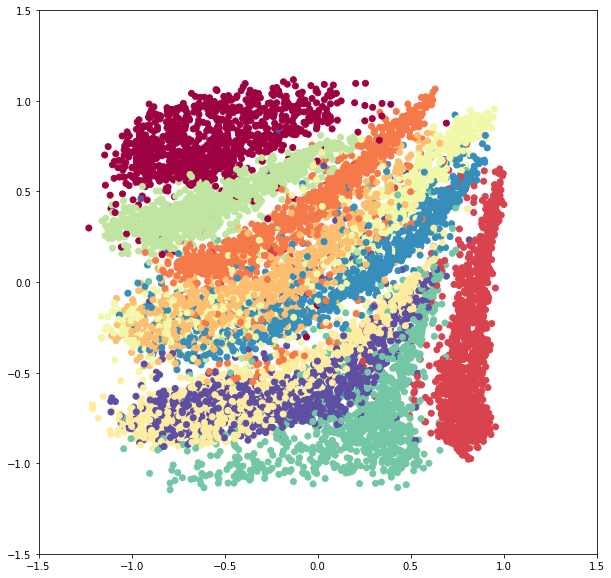

41 0.0006287455891569455 0.031083882958910906
42 0.0006221623882651329 0.03326323546302585
43 0.0006252739205956457 0.033895005201236506
44 0.000630539677043756 0.03344078563427487
45 0.0006208427160978317 0.03164103963433173
46 0.000619720066090425 0.032452215675633556
47 0.0006185462931791937 0.032575667591783375
48 0.000621947226921717 0.03202138448389955
49 0.0006226995592315991 0.03125314274356483
50 0.0006218434646725654 0.031849298286980715


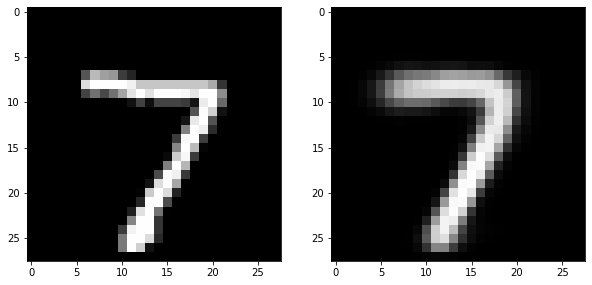

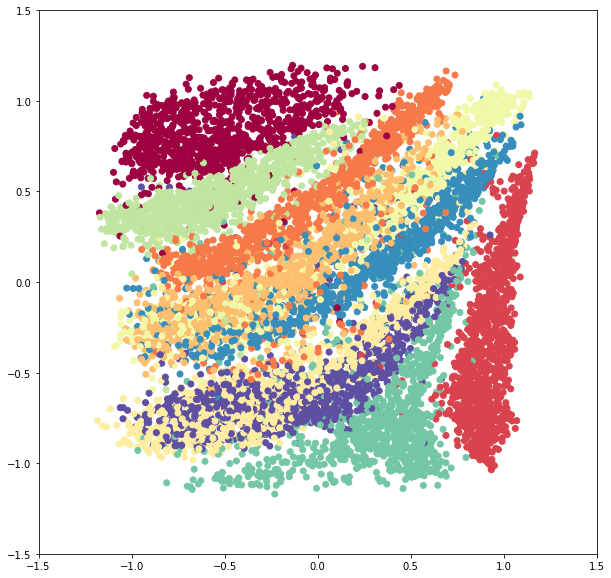

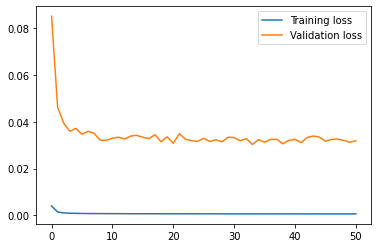

In [12]:
model = AE(16, 2).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.9)

train(model, optimizer, 51, train_loader, test_loader, "unif", True)

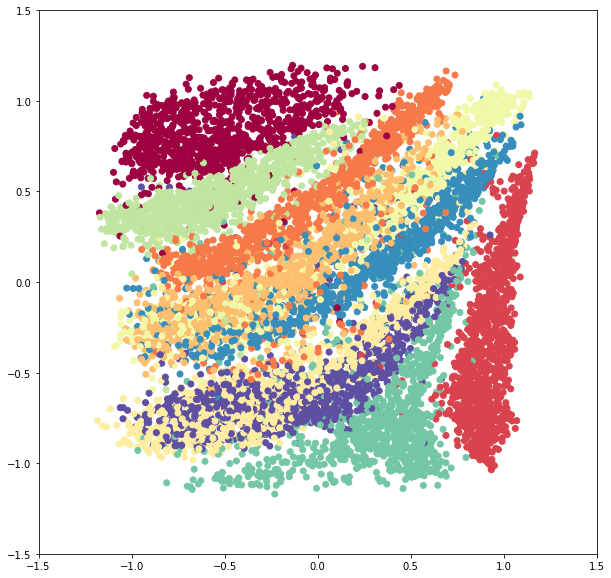

In [13]:
plot_latent(model, test_loader)

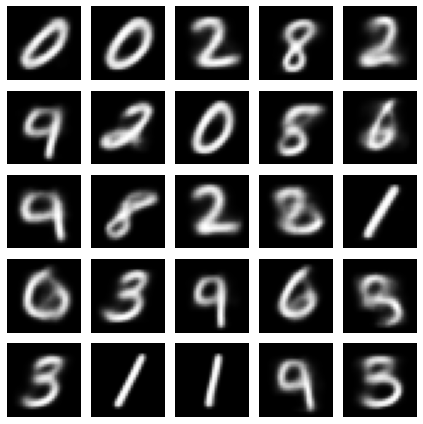

In [14]:
val_mnist(model)

#### Latent=Ring

  0%|          | 0/51 [00:00<?, ?it/s]

0 0.0050292713026205684 0.10830025885480281


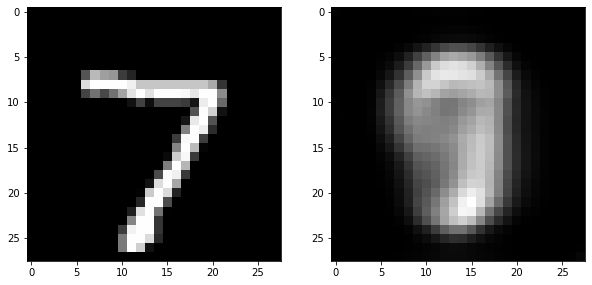

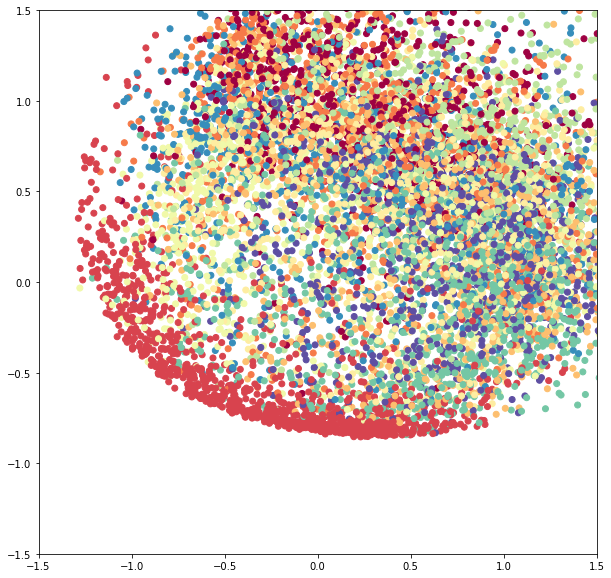

1 0.0016943630804618199 0.05706800833439674
2 0.0012155488754312205 0.05306185656390822
3 0.0010438432206710177 0.04419486769757713
4 0.0009579200997948641 0.04350084268425505
5 0.0009058365866541865 0.04414947338687916
6 0.0008616012493769329 0.03829254251651871
7 0.0008336767370502154 0.037818266060976935
8 0.0008218078384796781 0.03824467083421378
9 0.0008107253447175026 0.03696992515494077
10 0.0007973654851317403 0.036411527931071316


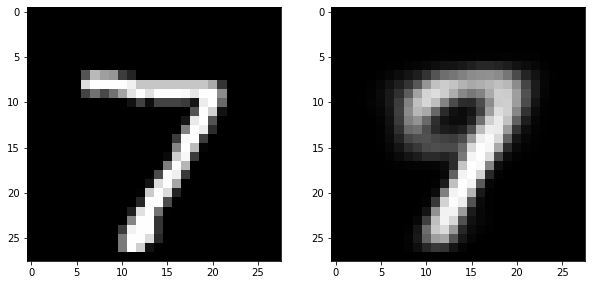

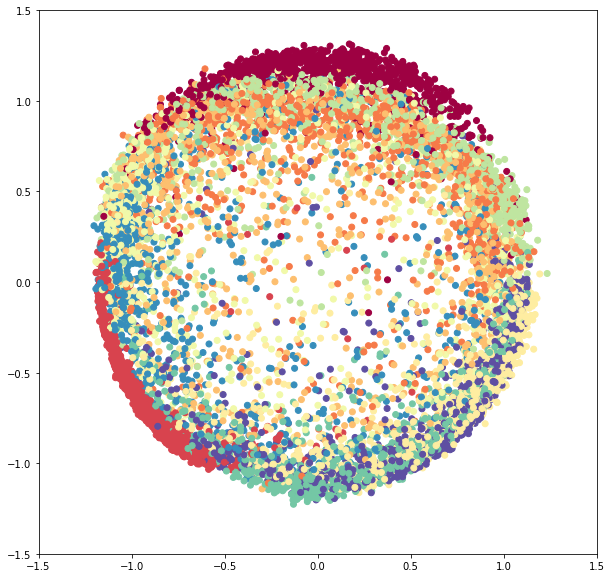

11 0.0007927515789866443 0.03735466790906252
12 0.0007747568612297376 0.03626640865835138
13 0.0007661012252171836 0.036121087214245964
14 0.0007638044362266859 0.03524168679853693
15 0.000755045661330223 0.033956358381829706
16 0.0007474171176552775 0.03506120887343971
17 0.0007393259649475417 0.03390567861318874
18 0.0007382834772268934 0.03448974775275388
19 0.000728061931828658 0.033724089420903415
20 0.000730840421716372 0.034316799418923384


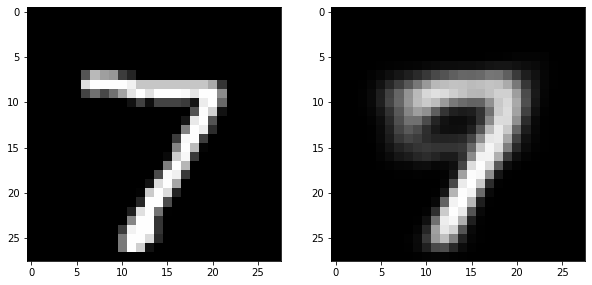

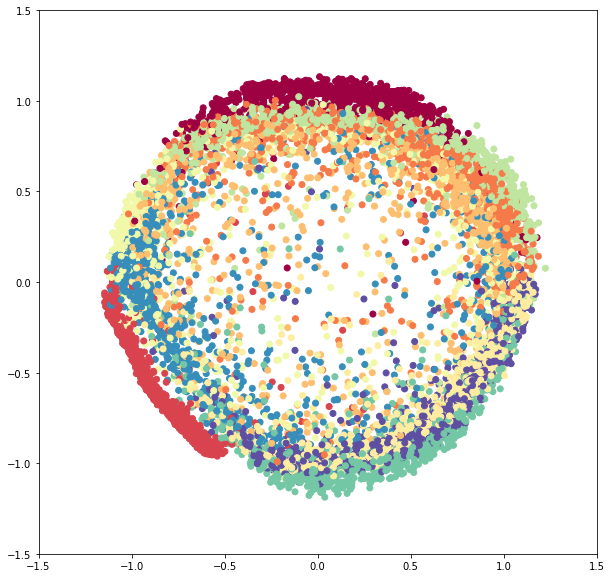

21 0.0007275141914685568 0.034893319927179776
22 0.0007203432306647305 0.03273707277739581
23 0.0007167658254504199 0.03353230797718413
24 0.0007187679583827658 0.03367872372531472
25 0.0007090181032816566 0.03339218865104091
26 0.0007049560541907949 0.03522597861508973
27 0.0007068873489896459 0.033102874938672346
28 0.0007004543234904605 0.034363625529475104
29 0.0007089842632412909 0.03461194499291646
30 0.0006952874829371772 0.03335428986543665


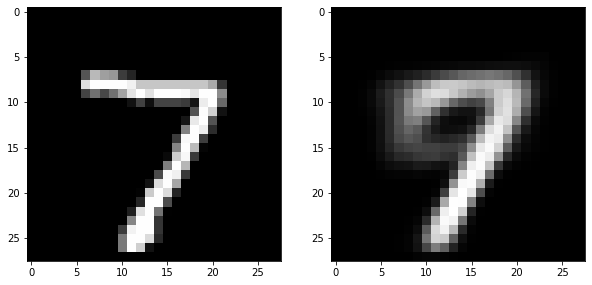

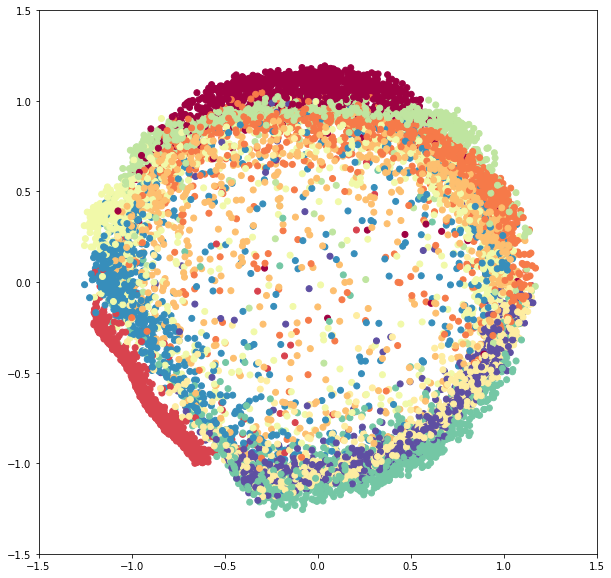

31 0.00069519349137942 0.032710066199088436
32 0.0006966966882348057 0.033154983290682394
33 0.0006901903276642161 0.03208001764913718
34 0.0006899946441253028 0.03287042884197765
35 0.0006826702063282332 0.03275807325641949
36 0.0006857560565074284 0.031760182725592924
37 0.0006780647868911426 0.03146118089889947
38 0.0006785003468394277 0.033246591871681684
39 0.0006792531758546828 0.03259499204722932
40 0.0006688244462013245 0.030974207422175347


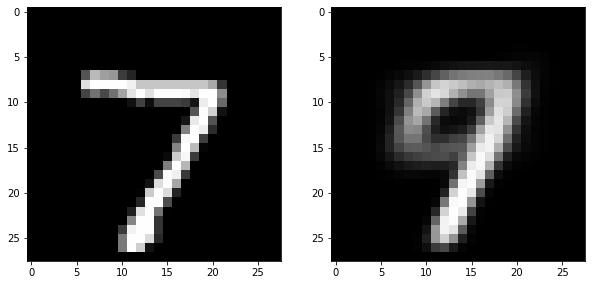

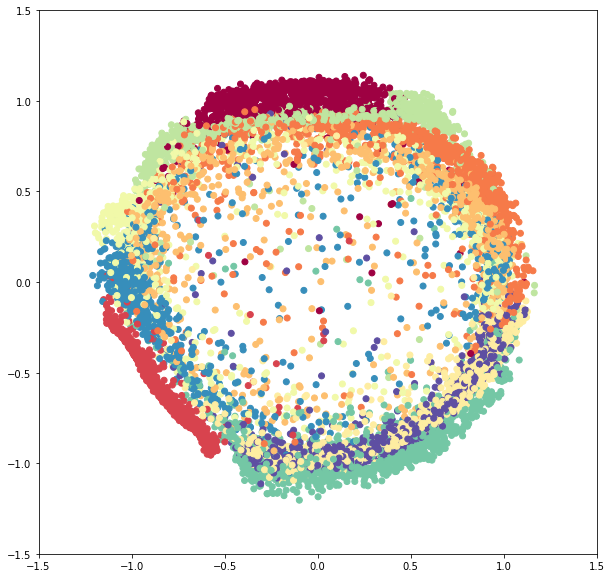

41 0.0006697569082180659 0.03238728180372963
42 0.0006742019991079963 0.03173940779028323
43 0.0006721125513315198 0.031158134189490882
44 0.000666364971299966 0.030897587725220207
45 0.0006695757990082105 0.03194252577440712
46 0.0006671898007392885 0.030960580714927695
47 0.0006701048930486045 0.030365211085770456
48 0.0006612370029091835 0.030512059187760558
49 0.0006638277019063629 0.03185144401848697
50 0.0006557639429966609 0.03063985231383064


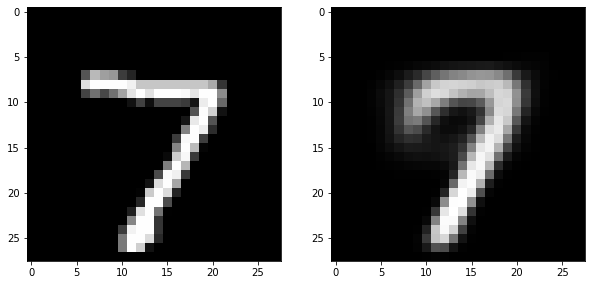

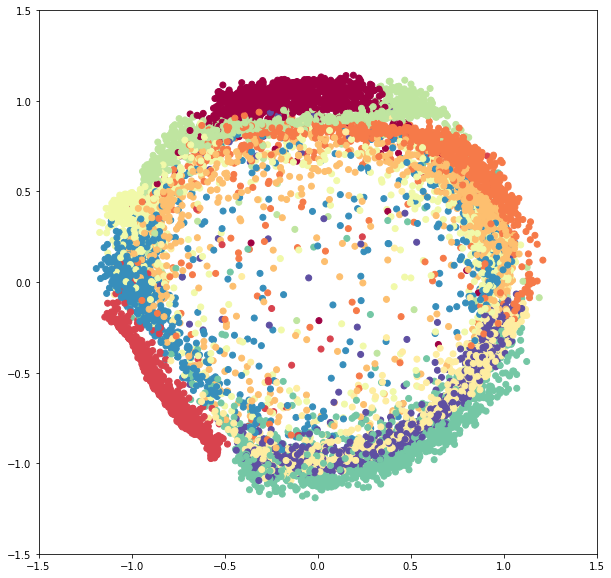

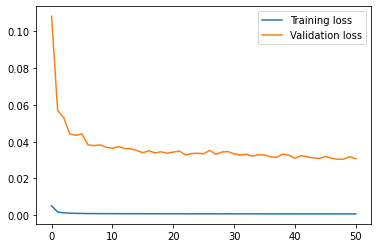

In [18]:
model = AE(16, 2).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.9)

train(model, optimizer, 51, train_loader, test_loader, "ring", True)

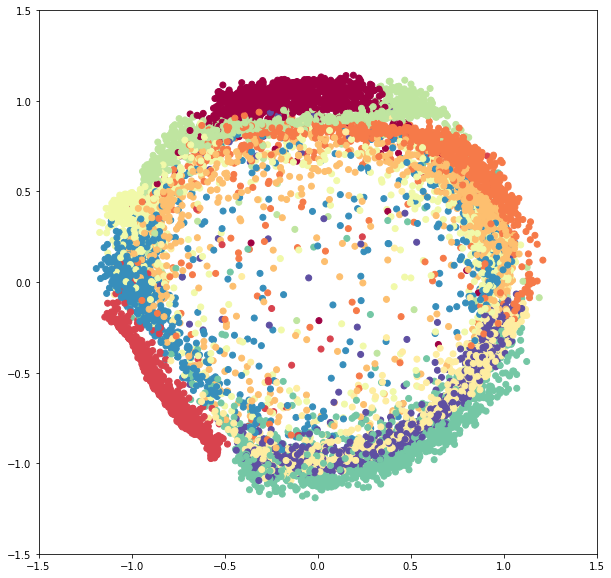

In [19]:
plot_latent(model, test_loader)

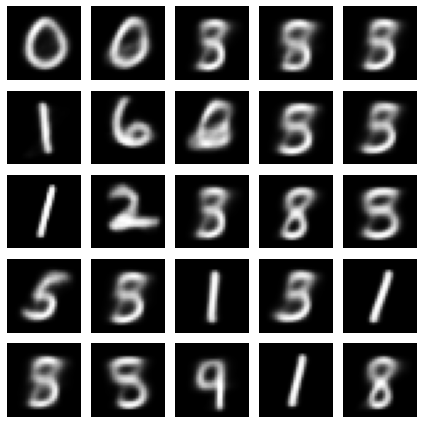

In [20]:
val_mnist(model)

#### Latent=Circle

  0%|          | 0/51 [00:00<?, ?it/s]

0 0.0025552322203914336 0.027639915815557536


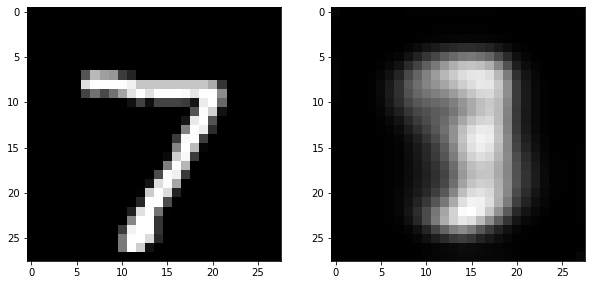

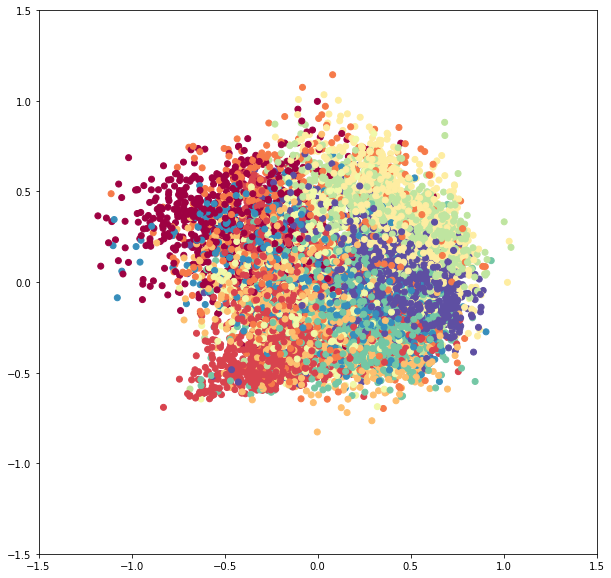

1 0.0010292600065469745 0.029768656927366226
2 0.0009010719090700147 0.024258812080128506
3 0.0008087261910239852 0.022070055378202242
4 0.0007630663424730301 0.021479987932113222
5 0.0007212423766652743 0.020473240666424693
6 0.0006999724800388017 0.019226569182480484
7 0.0006850003749132159 0.01971456552513491
8 0.0006759418398141861 0.019649355687177218
9 0.0006666749472419419 0.019606434421750685
10 0.0006606535146633783 0.01939579383871807


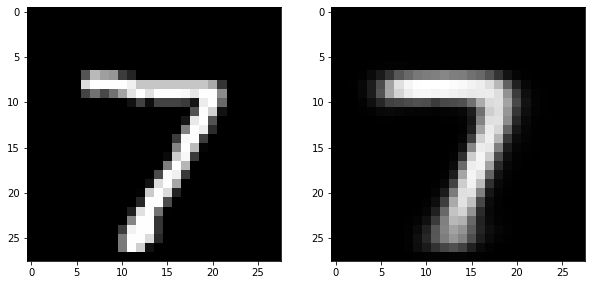

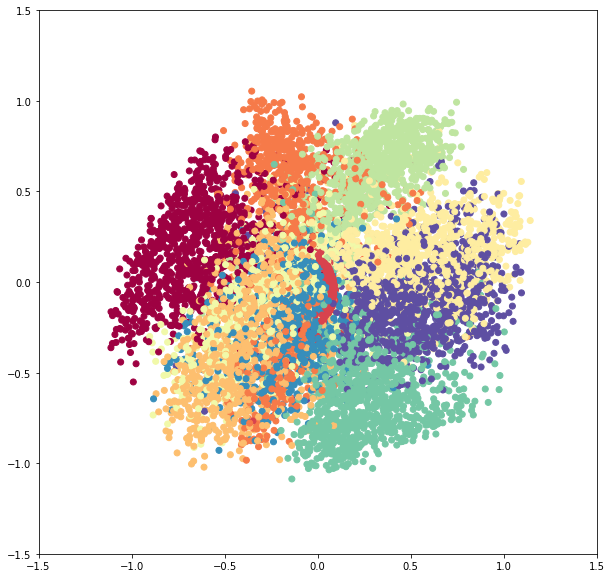

11 0.0006543446481227875 0.019289196278459538
12 0.0006452983195583025 0.02010085557501156
13 0.0006442054768403371 0.018455557019327776
14 0.0006355389734109242 0.018511767067705482
15 0.0006312323376536364 0.018540999486137882
16 0.0006263018111387888 0.018276570457072493
17 0.0006253481075167659 0.01844843958144466
18 0.0006232835168639816 0.018957841355865375
19 0.0006205711449186007 0.018956376715732838
20 0.0006168939058979353 0.01851614313229871


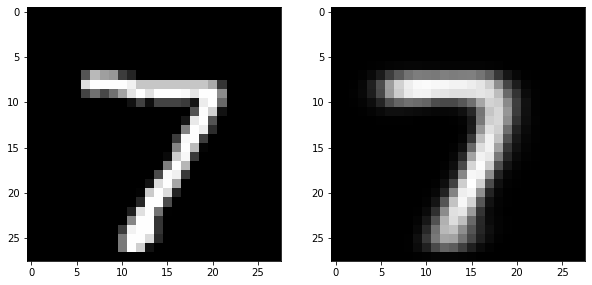

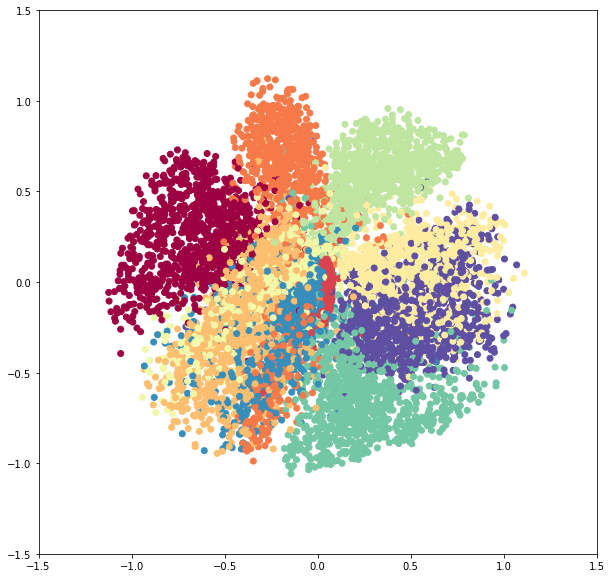

21 0.0006138201102614402 0.018245675895636835
22 0.0006084328005711238 0.01869652243836905
23 0.0006057268083095551 0.018942131080661718
24 0.0006080792928735417 0.018208193872421504
25 0.0006031517187754309 0.01807459277181199
26 0.0006000180602073671 0.018073321828922143
27 0.0005974378551046054 0.017861608255166597
28 0.0005968246092398959 0.01779731244634325
29 0.0005967447434862455 0.01819893687415999
30 0.0005967432687679927 0.018816116045767696


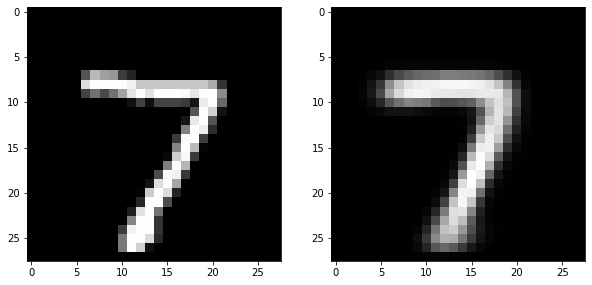

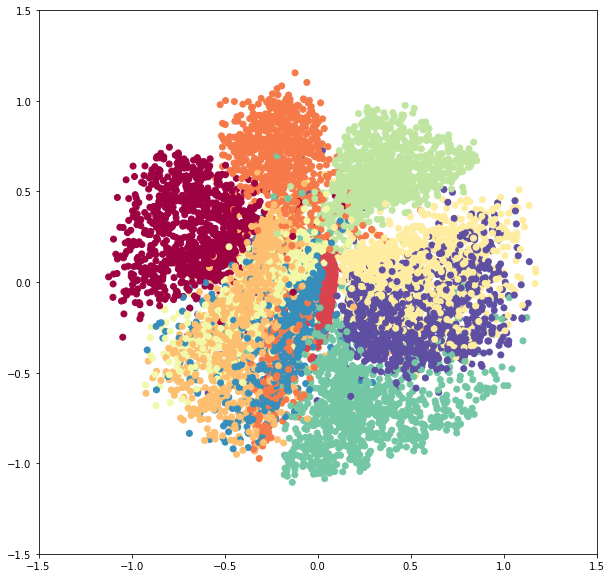

31 0.0005947929739952088 0.017987790386588237
32 0.0005945105751355487 0.017856320098470956
33 0.000591322190562884 0.018125092259611186
34 0.000587102579077085 0.017929941264037696
35 0.0005894080147147179 0.018293965667390975
36 0.0005853274653355279 0.018057582560724345
37 0.0005874612872799238 0.017867344577377216
38 0.0005829827452699343 0.01812110044442998
39 0.0005843239416678746 0.018032975399646517
40 0.0005786484991510709 0.01784923625961184


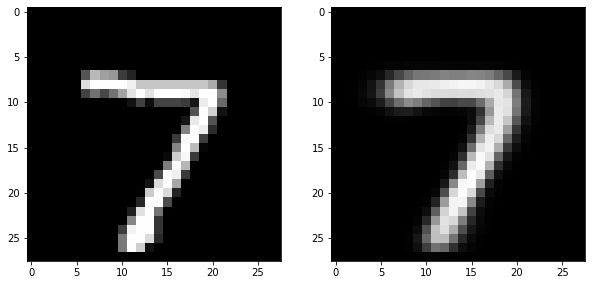

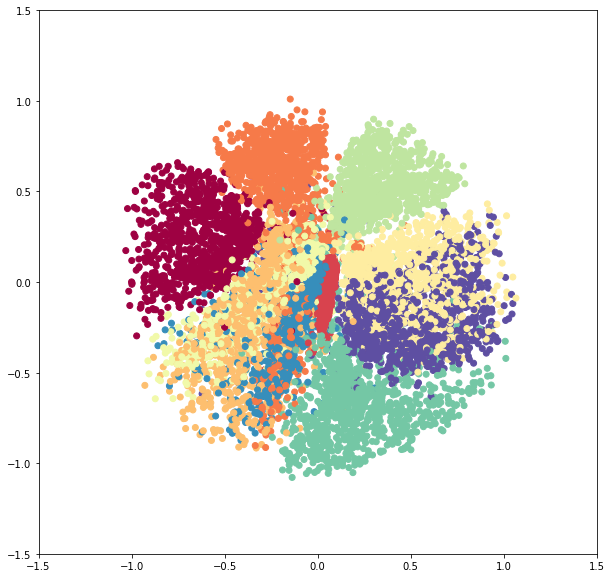

41 0.0005770953605572383 0.017901022707263882
42 0.0005812600870927175 0.017836258356896832
43 0.0005736308867732683 0.018101533717169358
44 0.0005791478301088014 0.017700959901554517
45 0.0005787443538506824 0.017638598116465842
46 0.000574184880157312 0.01840953217944303
47 0.0005776469578345614 0.018414757547739406
48 0.0005715964540839194 0.017905050894608514
49 0.0005744307408730188 0.01741789919606889
50 0.0005704103335738183 0.017648212552165834


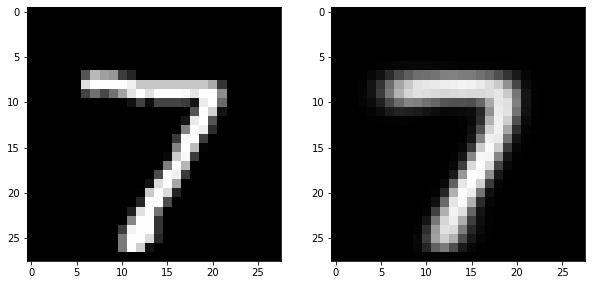

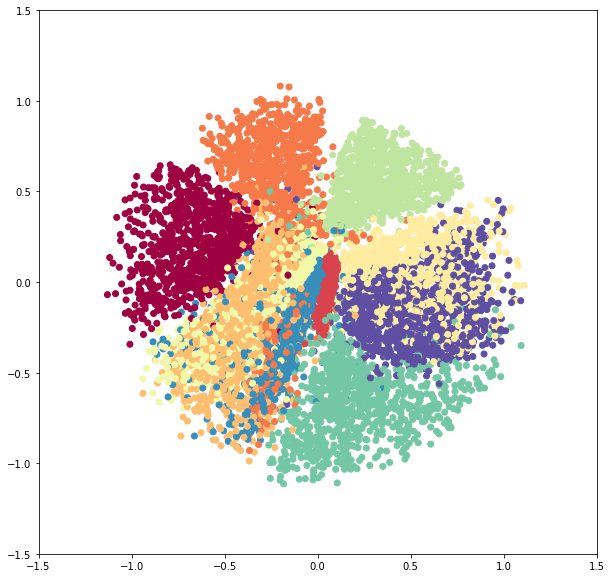

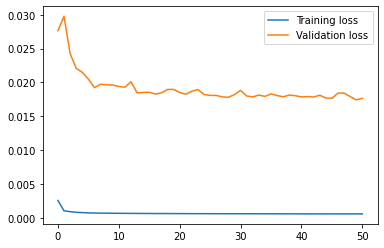

In [24]:
model = AE(16, 2).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.9)

train(model, optimizer, 51, train_loader, test_loader, "circle", True)

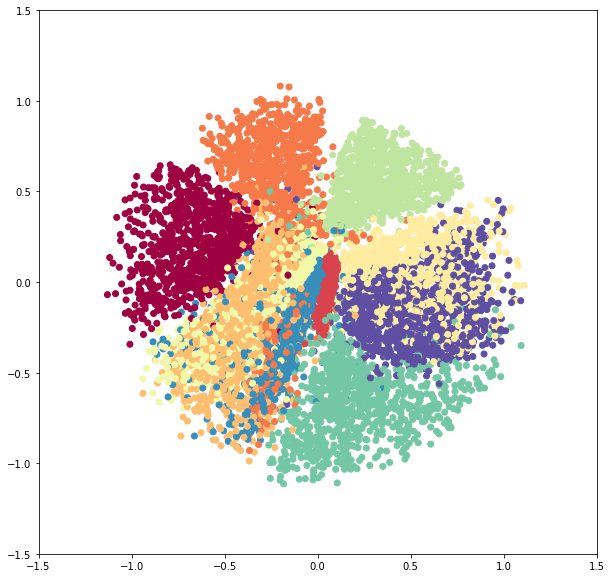

In [25]:
plot_latent(model, test_loader)

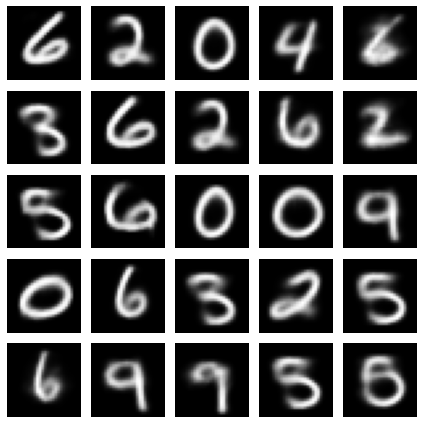

In [26]:
val_mnist(model)